In [1]:
import numpy
import matplotlib.pyplot as pyplot
import Transition_Search as trans_search
import time

# Finding Transitions for Rydberg Sensing

Rydberg atoms make excellent sensors of external electromagnetic fields over a wide range of frequencies including the RF, microwave and terahertz bands. It is often necessary to identify which atomic transitions fall within a particular frequency range and compare their properties. It was primarily written to identify transitions within the THz band (100 GHz to 10 THz) for a 3-photon excitation scheme in caesium. For further details on this use case see [[1,2,3]](#References).

The function in the `Transition_Search` module searches through all atomic transitions within given parameters to identify those in the frequency range of interest. It relies on the Python package ARC [(Alkali Rydberg Calculator)](https://arc-alkali-rydberg-calculator.readthedocs.io/en/latest/), and I cannot be held responsible for any errors therein. For example the frequency of the transitions will depend on the values of the quantum defects used by ARC which are outdated for caesium. This can result in errors of up to 100 MHz. 

## Searching for transitions

The `get_all_trans` function creates an array of all possible transitions within a certain frequency range for a specified atom type. It searches through all atomic transitions and stores details of those that have properties within the specified parameter limits.

Args:
 - `freq_range` (tuple of floats): Frequency range in which to search for possible Rydberg transitions (in GHz). For example (500, 700) will search for all transitions between 500 GHz and 700 GHz.

 - `atom_type` (str `'Cs'` or `'Rb'`, optional): The atomic species to consider. Default is Cs (caesium), Rb is rubidium 87.
 - `ground` (tuple of floats, optional): The state from which we excite to Rydberg in the form $(n,l,j)$ e.g. (7,0,0.5) corresponds to $7\rm{S}_{1/2}$. (Default is `'default'` which corresponds to $7\rm{S}_{1/2}$ in Caesium, and $6\rm{S}_{1/2}$ for Rubidium.).
 - `min_dme` (float, optional): the minimum value of the dipole matrix element (DME) to be stored (in units $a_0e$). Transitions with DME less than this will not appear in the output array. Default is $5 a_0e$.
 - `nmax` (float, optional): the maximum value of principal quantum number $n$ that will be considered. Default is 80.
 - `ryd_laser_range` (tuple of floats, optional): wavelength range of the laser used to excite from the specified 'ground' state to the $R_1$ Rydberg state (in nm). Default is (700,1000) corresponding to the approximate range of a Titanium:Sapphire laser. 
 - `save` (bool, optional): whether the output array should be saved. Filename will be "Transition_Search_{frequency_range}GHz_{atom_type}\_from_{ground}.csv". Default is `True`.
 
Returns:
 - `data_arr` (2darray): details of all transitions within the specified parameter ranges. In order [$n_1$, $l_1$, $j_1$, $n_2$, $l_2$, $j_2$, Transition frequency (GHz), DME ($a_0e$), Wavelength from chosen 'ground' state to Rydberg state $R_1$ (nm), DME of transition from 'ground' state to Rydberg state $R_1$ ($a_0e$)]
 
This function only considers dipole allowed transitions ($\Delta l = \pm1$) and the value of the dipole matrix element given is for $\pi$ transitions using the `getDipoleMatrixElement` function from ARC (from/to $m_F = 1/2$ as this exists for all $l$ states). This could be changed to be just the radial part of the matrix element (`getRadialMatrixElement`) which would neglect the angular/polarisation dependence and need to specify type of transition ($\pi, \sigma^+$ or $\sigma^-$).

### Examples

Imagine we are doing a 3-photon excitation in Caesium to an initial Rydberg state $R_1$, from which we want to couple to another Rydberg state $R_2$ using a THz field. We want to be able to identify all transitions $R_1 \to R_2$ that lie in the range 500 GHz to 600 GHz, and make sure that we can address the state $R_1$ using our choice of Rydberg laser.

To begin with, assume we are exciting to the $R_1$ Rydberg state from the $7\rm{S}_{1/2}$ state (the 'ground' state in the function) using a Titanium:Sapphire laser which has a wavelength range of around 700nm to 1000nm. Since these 'ground' state and wavelength range parameters are the defaults they don't need to be explicitly specified. We will turn off the automatic saving of the array by setting `save = False`.

In [3]:
freq_range = (500,600) #GHz
data = trans_search.get_all_trans(freq_range, save = False)
print(data.shape)

Exciting to Rydberg from 7S1/2 (in Cs)
(188, 10)


The function identifies 188 possible transitions with these parameters. We can plot them to visualise their properties more easily.

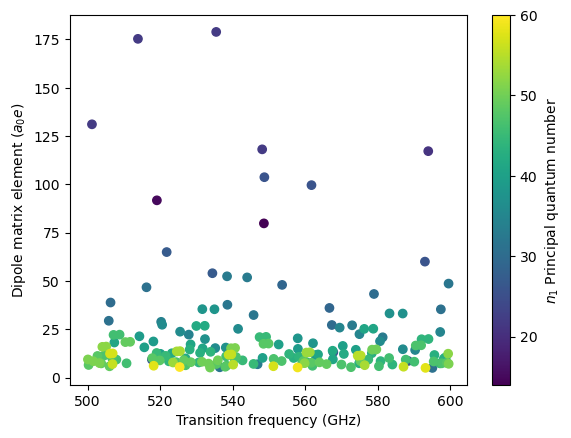

In [4]:
r1_states = data[:,:3] #n,l,j of the initial Rydberg state (R_1)
r2_states = data[:,3:6] #n,l,j of the final Rydberg state (R_2)
freqs = data[:,6] #frequency of the transition R_1 -> R_2 (in GHz)
dmes = data[:,7] #dipole matrix element of the transition R_1 -> R_2 (in a_0 e)
laser_wvls = data[:,8] #wavelength of the transition ground -> R_1 (in a_0 e)
laser_dmes = data[:,9] #dipole matrix element of the transition ground -> R_1 (in a_0 e)

pyplot.figure()
pyplot.scatter(freqs, dmes, c = r1_states[:,0])
pyplot.xlabel('Transition frequency (GHz)')
pyplot.ylabel(r'Dipole matrix element ($a_0 e$)')
pyplot.colorbar(label = '$n_1$ Principal quantum number')
pyplot.show()

From this we can see that the strongest transitions (those with the largest dipole matrix elements) are at lower principal quantum numbers. Note that in the plot there are no transitions with dipole matrix elements $<5a_0e$. These have been disregarded by the `min_dme=5` setting in the function.

If instead of a Ti:Sapph we have a laser with a more limited wavelength range (800 - 880 nm) we can do another search and specify the `ryd_laser_range` parameter.

In [5]:
freq_range = (500,600) #GHz
data = trans_search.get_all_trans(freq_range, ryd_laser_range = (800, 880), save = False)
print(data.shape)

Exciting to Rydberg from 7S1/2 (in Cs)
(2, 10)


Now there are only 2 possible candidates. We can print them and their corresponding transition frequencies.

In [6]:
spdf = ['S', 'P', 'D', 'F']
for i in range(data.shape[0]):
    [n1,l1,j1,n2,l2,j2,freq,dme,ryd1,ryd2] = data[i,:]
    print('{:.0f}{}{:.0f}/2 -> {:.0f}{}{:.0f}/2 at {:.2f} GHz'.format(n1, spdf[int(l1)], j1*2, n2, spdf[int(l2)], j2*2, freq))

14P3/2 -> 13D5/2 at 548.58 GHz
15P1/2 -> 14D3/2 at 519.07 GHz


## References

[1] Lucy A. Downes et al., *Full-Field Terahertz Imaging at Kilohertz Frame Rates Using Atomic Vapor* Phys. Rev. X **10** 011027 (2020) [https://journals.aps.org/prx/abstract/10.1103/PhysRevX.10.011027](https://journals.aps.org/prx/abstract/10.1103/PhysRevX.10.011027)

[2] Lucy A. Downes, Lara Torralbo-Campo and Kevin J. Weatherill, *A practical guide to terahertz imaging using thermal atomic vapour* New J. Phys. **25** 035002 (2023) [https://iopscience.iop.org/article/10.1088/1367-2630/acb80c/meta](https://iopscience.iop.org/article/10.1088/1367-2630/acb80c/meta)

[3] Lucy A. Downes, *A High-speed THz Imaging System based on THz-to-optical Conversion in Atomic Vapour* PhD Thesis, Durham University (2020) [https://etheses.dur.ac.uk/13797/](https://etheses.dur.ac.uk/13797/)